<a href="https://colab.research.google.com/github/safeai-snu/TimeSeriesAI/blob/main/ch1/ch1_4_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.17.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/main/data/train.csv', index_col=0)
val_df =  pd.read_csv('https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/main/data/val.csv', index_col=0)
test_df =  pd.read_csv('https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/main/data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [6]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [7]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [8]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## CNN

### Single-step model

In [9]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['traffic_volume'])

In [10]:
# Values obtained from chapter 1.1_RNN

mae_val = [0.083, 0.068, 0.033, 0.03]
mae_test = [0.081, 0.068, 0.029, 0.026]

In [11]:
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0713 - mean_absolute_error: 0.1777 - val_loss: 0.0062 - val_mean_absolute_error: 0.0586
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0061 - mean_absolute_error: 0.0566 - val_loss: 0.0042 - val_mean_absolute_error: 0.0491
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0046 - mean_absolute_error: 0.0501 - val_loss: 0.0032 - val_mean_absolute_error: 0.0416
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0038 - mean_absolute_error: 0.0452 - val_loss: 0.0028 - val_mean_absolute_error: 0.0386
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0035 - mean_absolute_error: 0.0430 - val_loss: 0.0029 - val_mean_absolute_error: 0.0403
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0033 - mean_absolute_error: 0.0414 - val_loss: 0.0026 - val_mean_absolute_error: 0.0381
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0031 - mean_absolute_error: 0.

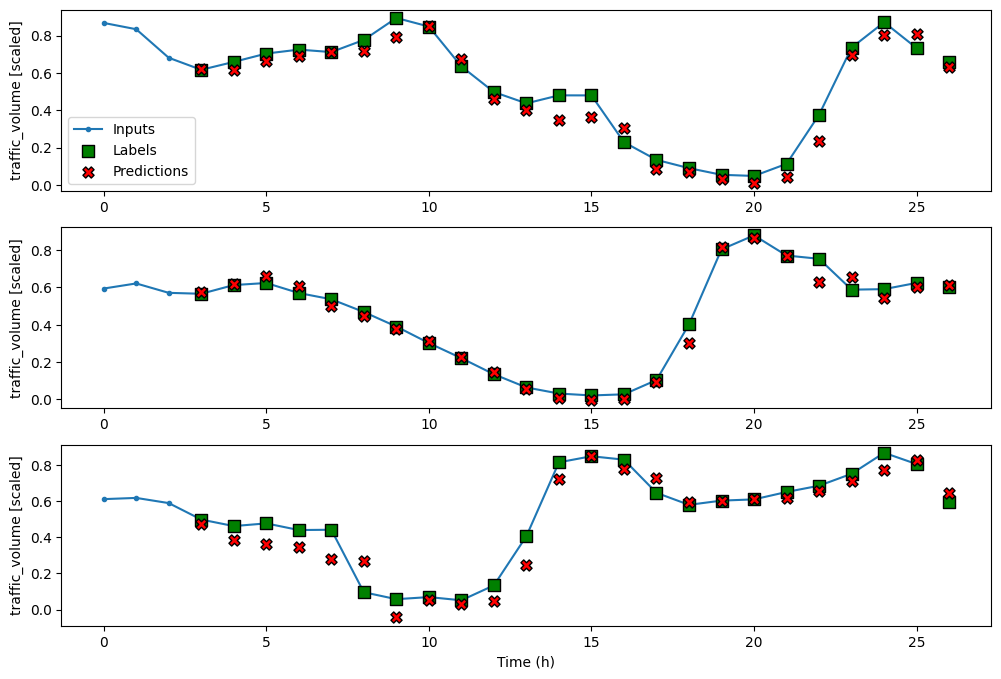

In [12]:
wide_conv_window.plot(cnn_model)

plt.savefig('./CH1.2_F05_peixeiro.png', dpi=300)

#### CNN + LSTM

In [13]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0789 - mean_absolute_error: 0.2022 - val_loss: 0.0071 - val_mean_absolute_error: 0.0659
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0063 - mean_absolute_error: 0.0570 - val_loss: 0.0048 - val_mean_absolute_error: 0.0500
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0052 - mean_absolute_error: 0.0525 - val_loss: 0.0041 - val_mean_absolute_error: 0.0470
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0043 - mean_absolute_error: 0.0478 - val_loss: 0.0036 - val_mean_absolute_error: 0.0436
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0438 - val_loss: 0.0029 - val_mean_absolute_error: 0.0403
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0033 - mean_absolute_error: 0.0420 - val_loss: 0.0029 - val_mean_absolute_error: 0.0397
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0032 - mean_absolute_error: 0.0405 -

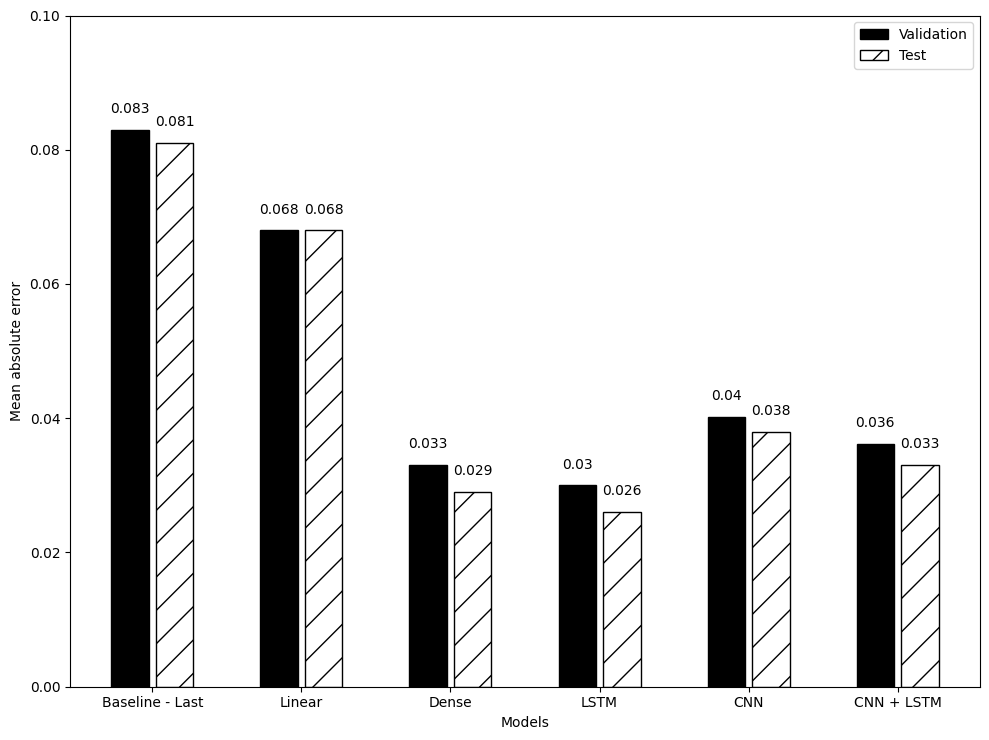

In [14]:
mae_val.extend([v[1] for v in val_performance.values()])
mae_test.extend([v[1] for v in performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('./CH1.2_F06_peixeiro.png', dpi=300)

### Multi-step model

In [15]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['traffic_volume'])

In [16]:
# Values obtained from chapter 1.1 RNN

ms_mae_val = [0.352, 0.347, 0.088, 0.078, 0.070]
ms_mae_test = [0.347, 0.341, 0.076, 0.064, 0.058]

In [17]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0787 - mean_absolute_error: 0.1989 - val_loss: 0.0165 - val_mean_absolute_error: 0.0838
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0145 - mean_absolute_error: 0.0802 - val_loss: 0.0158 - val_mean_absolute_error: 0.0832
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0139 - mean_absolute_error: 0.0785 - val_loss: 0.0154 - val_mean_absolute_error: 0.0822
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0136 - mean_absolute_error: 0.0779 - val_loss: 0.0154 - val_mean_absolute_error: 0.0853
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0134 - mean_absolute_error: 0.0770 - val_loss: 0.0148 - val_mean_absolute_error: 0.0796
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0133 - mean_absolute_error: 0.0767 - val_loss: 0.0148 - val_mean_absolute_error: 0.0813
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0132 - mean_absolute_error: 0.0763 - 

#### CNN + LSTM

In [18]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_window)

ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0833 - mean_absolute_error: 0.2185 - val_loss: 0.0172 - val_mean_absolute_error: 0.0885
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0148 - mean_absolute_error: 0.0818 - val_loss: 0.0164 - val_mean_absolute_error: 0.0840
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0141 - mean_absolute_error: 0.0790 - val_loss: 0.0160 - val_mean_absolute_error: 0.0844
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0138 - mean_absolute_error: 0.0777 - val_loss: 0.0156 - val_mean_absolute_error: 0.0813
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0135 - mean_absolute_error: 0.0768 - val_loss: 0.0155 - val_mean_absolute_error: 0.0803
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0134 - mean_absolute_error: 0.0763 - val_loss: 0.0158 - val_mean_absolute_error: 0.0798
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0132 - mean_absolute_error:

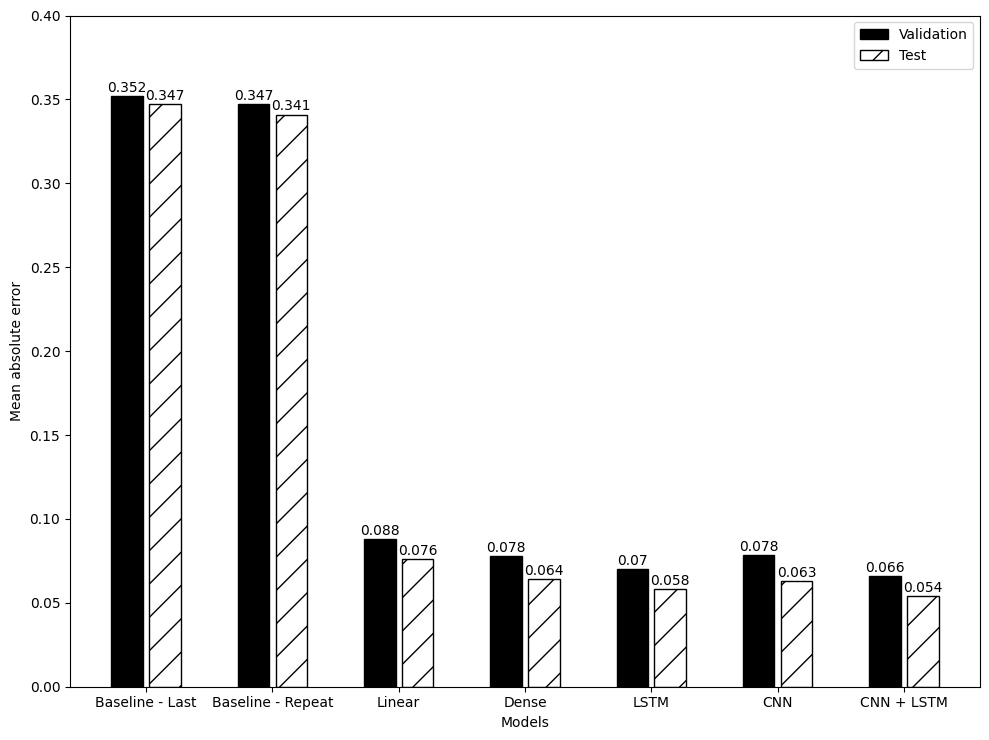

In [19]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(7)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('./CH1.2_F07_peixeiro.png', dpi=300)

### Multi-output model

In [20]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['temp', 'traffic_volume'])

In [21]:
# Values from chapter 1.1 RNN

mo_mae_val = [0.048, 0.039, 0.023, 0.020]
mo_mae_test = [0.047, 0.036, 0.020, 0.017]

In [22]:
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0344 - mean_absolute_error: 0.1246 - val_loss: 0.0034 - val_mean_absolute_error: 0.0396
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0372 - val_loss: 0.0022 - val_mean_absolute_error: 0.0321
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0023 - mean_absolute_error: 0.0314 - val_loss: 0.0017 - val_mean_absolute_error: 0.0284
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0020 - mean_absolute_error: 0.0286 - val_loss: 0.0015 - val_mean_absolute_error: 0.0260
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0018 - mean_absolute_error: 0.0269 - val_loss: 0.0015 - val_mean_absolute_error: 0.0263
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0256 - val_loss: 0.0014 - val_mean_absolute_error: 0.0243
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0016 - mean_absolute_error: 0.0247 - 

In [23]:
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0497 - mean_absolute_error: 0.1486 - val_loss: 0.0043 - val_mean_absolute_error: 0.0424
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0037 - mean_absolute_error: 0.0399 - val_loss: 0.0023 - val_mean_absolute_error: 0.0336
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0024 - mean_absolute_error: 0.0323 - val_loss: 0.0018 - val_mean_absolute_error: 0.0288
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0020 - mean_absolute_error: 0.0290 - val_loss: 0.0018 - val_mean_absolute_error: 0.0292
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0019 - mean_absolute_error: 0.0278 - val_loss: 0.0016 - val_mean_absolute_error: 0.0271
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0018 - mean_absolute_error: 0.0265 - val_loss: 0.0017 - val_mean_absolute_error: 0.0314
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0017 - mean_absolute_error: 0

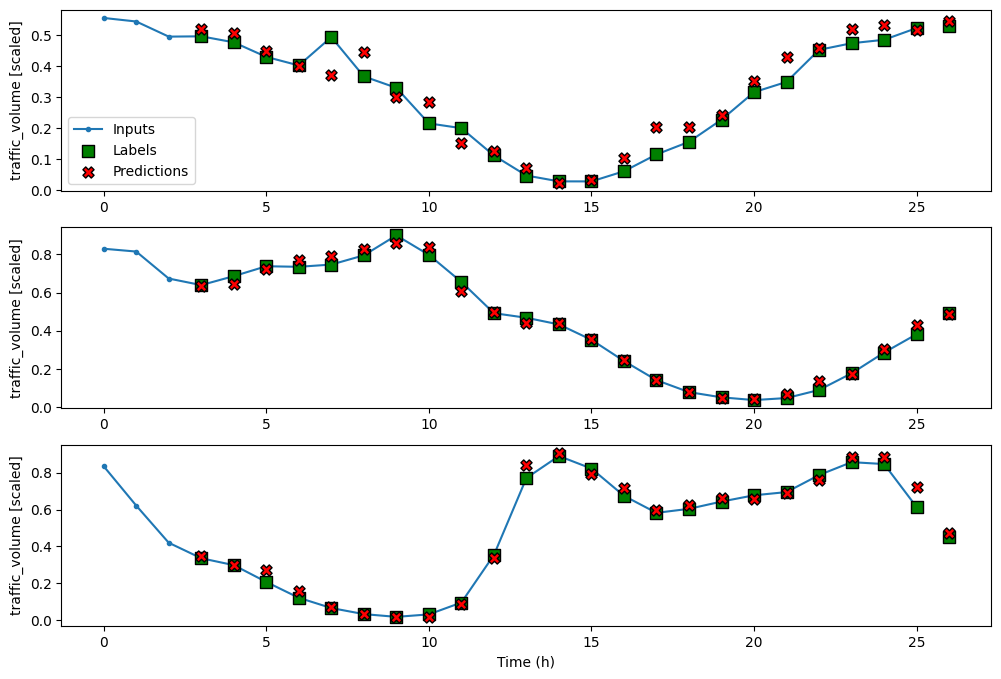

In [24]:
wide_mo_conv_window.plot(mo_cnn_lstm_model)

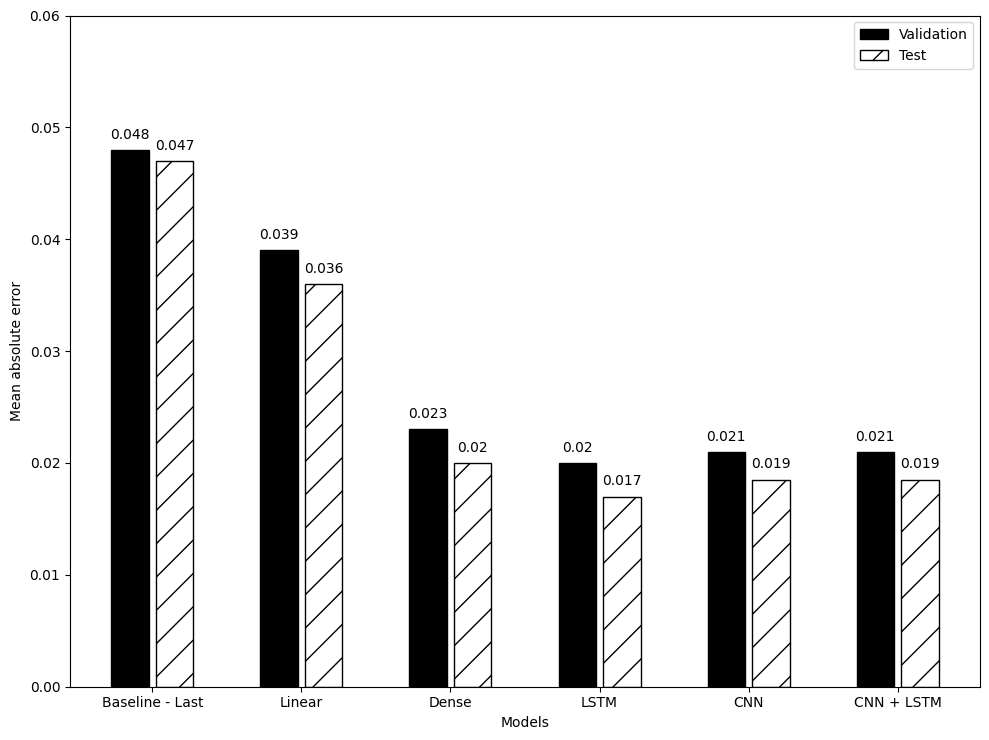

In [25]:
mo_mae_val.extend([v[1] for v in mo_val_performance.values()])
mo_mae_test.extend([v[1] for v in mo_performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('./CH1.2_F08_peixeiro.png', dpi=300)